1. Value-based methods with deep neural network [50 points]
Implement Q-learning and Exptected SARSA for both Acrobot-v1 1 and ALE/Assault-ram-v52
environments from the Gym suite using the following guidelines:
• Use a Neural Network approximation for Q, that is, if x is a vector representing the state
and a is the action vector, use Q value(x) = M LP (x; θ), where θ are the parameters of the
Value function you need to learn, Q ∈ Rm where m denotes the number of discrete actions.
• Model configuration: Initialize the parameters for the value function uniformly between
−0.001 and 0.001, we recommend using either a 2 or 3-layer Neural Network for the Value
function, with a hidden dimension of 256.
• Use an ϵ- greedy policy with three choices of ϵ and step-size parameters 1/4, 1/8, 1/16. and
run 50 learning trials with different initializations for the Value function, each having 1000
episodes, for each configuration. That means 3(ϵ’s) * 3 (step-sizes) * 50 runs * 1000 episodes.
• Repeat the Previous step using a replay buffer (with transitions randomly sampled) and do
gradient updates using a mini-batch of transitions. The capacity of the replay buffer is 1M.
• Plot training curves with the mean across seeds as lines and the standard deviation as a shaded
region. (Performance on the Y-axis, and the episode on the X-axis). Generate 18 graphs
covering all configurations per environment. Present separate plots for each environment,
with distinct graphs for settings with and without a replay buffer. Use green for Q-Learning
and red for Expected SARSA, differentiating hyperparameters with different line styles (e.g.,
solid, dashed).
• Implement all the methods using any automatic differentiation package, such as Py-
torch

In [1]:
# Implement Q-learning and Exptected SARSA for both Acrobot-v1 1 and ALE/Assault-ram-v52 environments from the Gym suite using the following guidelines:

# • Use a Neural Network approximation for Q, that is, if x is a vector representing the state and a is the action vector, use Q value(x) = M LP (x; θ), where θ are the parameters of the Value function you need to learn, Q ∈ Rm where m denotes the number of discrete actions.

# • Model configuration: Initialize the parameters for the value function uniformly between −0.001 and 0.001, we recommend using either a 2 or 3-layer Neural Network for the Value function, with a hidden dimension of 256.

# • Use an ϵ- greedy policy with three choices of ϵ and step-size parameters 1/4, 1/8, 1/16. and run 50 learning trials with different initializations for the Value function, each having 1000 episodes, for each configuration. That means 3(ϵ’s) * 3 (step-sizes) * 50 runs * 1000 episodes.

# • Repeat the Previous step using a replay buffer (with transitions randomly sampled) and do gradient updates using a mini-batch of transitions. The capacity of the replay buffer is 1M.

# • Plot training curves with the mean across seeds as lines and the standard deviation as a shaded region. (Performance on the Y-axis, and the episode on the X-axis). Generate 18 graphs covering all configurations per environment. Present separate plots for each environment, with distinct graphs for settings with and without a replay buffer. Use green for Q-Learning and red for Expected SARSA, differentiating hyperparameters with different line styles (e.g., solid, dashed).

# • Implement all the methods using any automatic differentiation package, such as Py-torch

In [ ]:
# env_name = 'Acrobot-v1'
env_name = 'Assault-ram-v5'

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import time
import math as math
import ale_py

# Hyperparameters
EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 50

# Environment
env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Neural Network
class QNetwork(nn.Module):
    def __init__(self, INPUT_DIM, OUTPUT_DIM):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
        # torch.nn.init.xavier_uniform_(self.fc1.weight)
        # torch.nn.init.xavier_uniform_(self.fc2.weight)
        # torch.nn.init.xavier_uniform_(self.fc3.weight)
        # self.fc1.bias.data.fill_(0.01)
        # self.fc2.bias.data.fill_(0.01)
        # self.fc3.bias.data.fill_(0.01)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Q-Learning
def q_learning(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork(state_dim, action_dim)
    # q_network_target = QNetwork()
    # q_network_target.load_state_dict(q_network.state_dict())
    q_network.to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        print(episode)
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                # next_q_values = q_network_target(next_state_batch)
                next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # for i in range(batch_size):
                #     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].max() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.max(dim=1).values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        # if episode % 100 == 0:
        #     q_network_target.load_state_dict(q_network.state_dict())
    return rewards

# Expected SARSA
def expected_sarsa(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    # q_network_target = QNetwork()
    # q_network_target.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        print(episode)
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                # next_q_values = q_network_target(next_state_batch)
                next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # for i in range(batch_size):
                #     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].mean() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.mean(dim=1) * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        # if episode % 100 == 0:
        #     q_network_target.load_state_dict(q_network.state_dict())
    return rewards


def run_experiment(lr, batch_size, replay_buffer_size, epsilon):
    random_seeds = np.random.randint(0, 1000, size=SEEDS)
    q_learning_rewards = np.zeros((SEEDS, EPISODES))
    expected_sarsa_rewards = np.zeros((SEEDS, EPISODES))
    for i, seed in enumerate(random_seeds):
        print(f'Run {i+1}/{SEEDS}')
        torch.random.seed(seed)
        np.random.seed(seed)
        q_learning_rewards[i] = q_learning(lr, batch_size, replay_buffer_size, epsilon)
        expected_sarsa_rewards[i] = expected_sarsa(lr, batch_size, replay_buffer_size, epsilon)
        pickle.dump(q_learning_rewards, open(f'RUN#{i}_ACROBOT_q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        pickle.dump(expected_sarsa_rewards, open(f'RUN#{i}_ACROBOT_expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
    q_learning_rewards_mean = q_learning_rewards.mean(axis=0)
    q_learning_rewards_std = q_learning_rewards.std(axis=0)
    expected_sarsa_rewards_mean = expected_sarsa_rewards.mean(axis=0)
    expected_sarsa_rewards_std = expected_sarsa_rewards.std(axis=0)
    plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
    plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
    plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
    plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()


In [3]:
# SEEDS = 1
# EPISODES = 100
# run_experiment(0.001, 64, 1000000, 0.25)

In [ ]:
import pickle
epsilons = [0.25, 0.125, 0.0625]
lrs = [1/4, 1/8, 1/16]
replay_buffers = [(1, 1), (32, 1000000)]
for epsilon in epsilons:
    for lr in lrs:
        for replay_buffer in replay_buffers:
            run_experiment(lr, replay_buffer[0], replay_buffer[1], epsilon)
            time.sleep(1)
            os.system('mv plot.png plots/{}_{}_{}_{}.png'.format(env_name, epsilon, lr, replay_buffer[0]))
            time.sleep(1)
            os.system('rm plot.png')
            time.sleep(1)

Run 1/50
0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1


KeyboardInterrupt: 

In [25]:
def BoltzmanPolicy(preds, temp):
    probs = torch.softmax(preds / temp, dim=1)
    a = torch.distributions.Categorical(probs).sample().item()
    return a, probs[0][a]


In [34]:
def reinforce(episodes, lr, gamma, T, decay, decay_rate, end_temp):
    rewards = []
    q_network = QNetwork(state_dim, action_dim)
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    temp = T
    end_temp = end_temp
    for i in range(episodes):
        if decay:
            temp = T - ((T - end_temp) * i / episodes)
        total_reward = 0
        if i % 100 == 0:
            print("EPISODE#", i)
        ep = []
        state, info = env.reset()
        done = False
        step = 0
        while not done and step < 1000:
            action, prob = BoltzmanPolicy(q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)), temp)
            next_state, reward, done, truncated, _= env.step(action)
            total_reward += reward
            ep.append((state, action, reward, prob))
            state = next_state
            step += 1
        grad = 0
        for t in range(len(ep)):
            G = sum([gamma**(i-t-1) * ep[i][2] for i in range(t, len(ep))])
            # print(G)
            grad += (gamma**t) * G * torch.log(max(prob,torch.tensor(1e-8)))
        optimizer.zero_grad()
        grad.backward()
        optimizer.step()
        rewards.append(total_reward)
    return rewards

In [38]:
def A2C(episodes, gamma, policy_lr,value_lr, T, decay, decay_rate, end_temp):
    policy_network = QNetwork(state_dim, action_dim)
    value_network = QNetwork(state_dim, 1)
    optimizer_actor = optim.Adam(policy_network.parameters(), lr=0.0001)
    optimizer_value = optim.Adam(value_network.parameters(), lr=0.001)
    rewards = []
    temp = T
    end_temp = end_temp
    for i in range(episodes):
        if decay:
            temp = T - ((T - end_temp) * i / episodes)
        total_reward = 0
        if i % 100 == 0:
            print("EPISODE#", i)
        state, info = env.reset()
        done = False
        step = 0
        policy_loss = 0
        value_loss = 0
        while not done  and step < 1000:
            with torch.no_grad():
                action, prob = BoltzmanPolicy(policy_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)), temp)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done:
                advantage = reward - value_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).detach()
            else:
                advantage = reward + gamma * value_network(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)).detach() - value_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).detach()
            preds = policy_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))[0]
            policy_loss -= torch.log(torch.exp(preds[action]/T)/torch.sum(torch.exp(preds/T))) * advantage
            value_loss +=  0.5*(reward + gamma * value_network(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)).detach() - value_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)))**2
            state = next_state
            step += 1
        mean_policy_loss = policy_loss / step
        mean_value_loss = value_loss / step
        optimizer_actor.zero_grad()
        optimizer_value.zero_grad()
        mean_policy_loss.backward()
        mean_value_loss.backward()
        optimizer_actor.step()
        optimizer_value.step()
        rewards.append(total_reward)
    return rewards


In [37]:
def run_experiment2(lr, T, decay, decay_rate, gamma, episodes, seeds):
    random_seeds = np.random.randint(0, 50, size=seeds)
    a2c_learning_rewards = np.zeros((seeds, EPISODES))
    reinforce_rewards = np.zeros((seeds, EPISODES))
    seeds = 10
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        torch.manual_seed(i)
        np.random.seed(i)
        a2c_learning_rewards[i] = A2C(episodes=episodes, gamma=gamma, policy_lr=lr, value_lr=lr, T=T, decay=decay, decay_rate=decay_rate, end_temp=decay_rate)
        reinforce_rewards[i] = reinforce(episodes=episodes, lr=lr, gamma=gamma, T=T, decay=decay, decay_rate=decay_rate, end_temp=decay_rate)
        pickle.dump(a2c_learning_rewards[i], open(f'RUN#{i}_ACROBOT_a2c_learning_rewards_{lr}_{T}_{decay}_{decay_rate}.pkl', 'wb'))
        pickle.dump(reinforce_rewards[i], open(f'RUN#{i}_ACROBOT_reinforce_rewards_{lr}_{T}_{decay}_{decay_rate}.pkl', 'wb'))
    a2c_learning_rewards_mean = a2c_learning_rewards.mean(axis=0)
    a2c_learning_rewards_std = a2c_learning_rewards.std(axis=0)/math.sqrt(seeds)
    reinforce_rewards_mean = reinforce_rewards.mean(axis=0)
    reinforce_rewards_std = reinforce_rewards.std(axis=0)/math.sqrt(seeds)
    plt.plot(a2c_learning_rewards_mean, label='A2C', color='green')
    plt.fill_between(range(EPISODES), a2c_learning_rewards_mean - a2c_learning_rewards_std, a2c_learning_rewards_mean + a2c_learning_rewards_std, color='green', alpha=0.2)
    plt.plot(reinforce_rewards_mean, label='Reinforce', color='red')
    plt.fill_between(range(EPISODES), reinforce_rewards_mean - reinforce_rewards_std, reinforce_rewards_mean + reinforce_rewards_std, color='red', alpha=0.2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig('plot.png')
    plt.show()

Run 1/10
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
Run 2/10
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
Run 3/10
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
Run 4/10
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISODE# 500
EPISODE# 600
EPISODE# 700
EPISODE# 800
EPISODE# 900
EPISODE# 0
EPISODE# 100
EPISODE# 200
EPISODE# 300
EPISODE# 400
EPISO

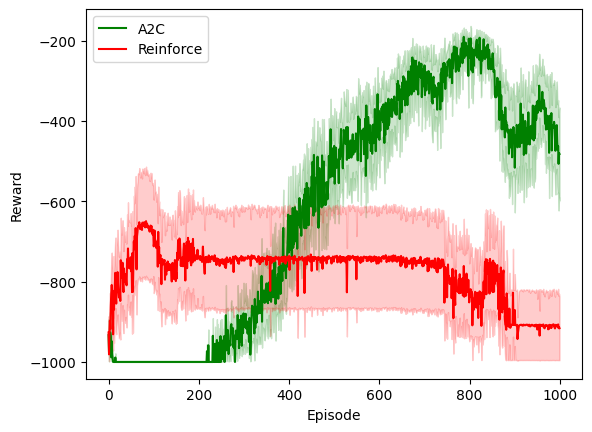

In [ ]:
T = [[3, True, 1]]
import pickle
#REINFORCE
lr = [3e-4]
SEEDS = 10
for stuff in T:
    run_experiment2(lr=lr[0], T=stuff[0], decay=stuff[1], decay_rate=stuff[2], gamma=0.99, episodes=1000, seeds=SEEDS)